In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

csv_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv"
df = pd.read_csv(csv_path)

print(df.head())
print("\nColumns:", df.columns)
print("\nNumber of samples:", len(df))


            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

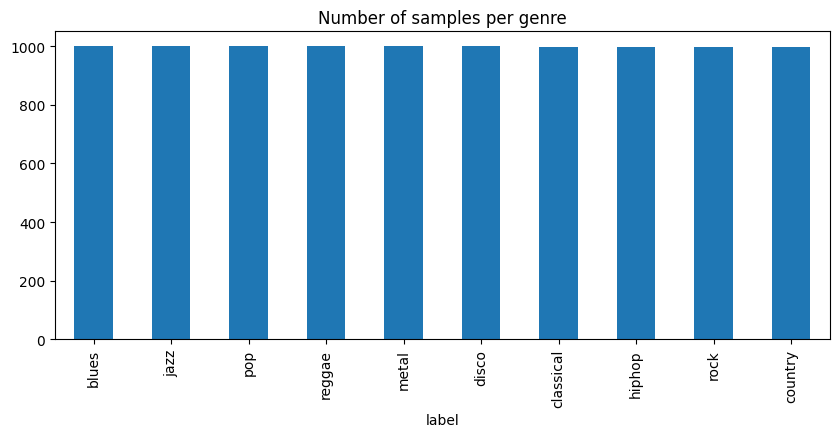

In [7]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', figsize=(10, 4))
plt.title("Number of samples per genre")
plt.show()


In [8]:
X = df.drop(columns=["filename", "label"])
genres = sorted(df["label"].unique())
y = torch.tensor([genres.index(lbl) for lbl in df["label"]], dtype=torch.long)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = torch.tensor(X_scaled, dtype=torch.float32)

print("Feature tensor shape:", X.shape)
print("Label tensor shape:", y.shape)

Feature tensor shape: torch.Size([9990, 58])
Label tensor shape: torch.Size([9990])


In [9]:
class FlowModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + num_classes + 1, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, z, t, style_onehot):
        if t.dim() == 1:
            t = t.unsqueeze(1)  # make sure t is [batch, 1]
        inp = torch.cat([z, style_onehot, t], dim=1)
        return self.net(inp)

            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

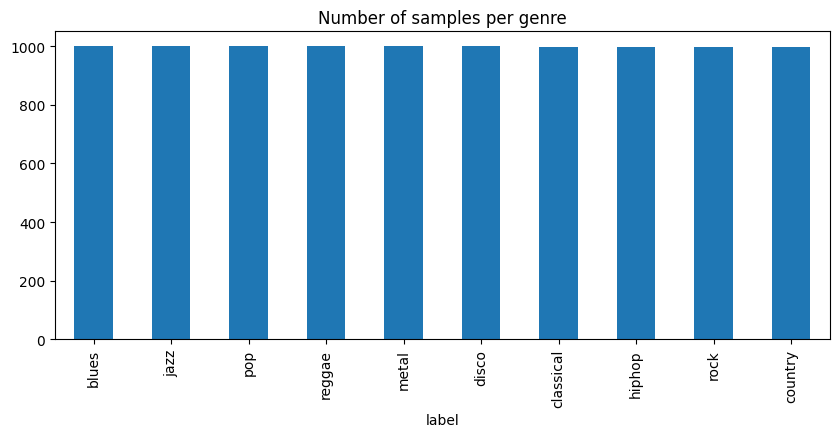

Feature tensor shape: torch.Size([9990, 58])
Label tensor shape: torch.Size([9990])
Epoch 1: loss=5.0208e-02
Epoch 2: loss=4.0904e-02
Epoch 3: loss=3.3665e-02
Epoch 4: loss=2.8144e-02
Epoch 5: loss=2.3999e-02
net.0.weight grad mean: 0.00017504944116808474
net.0.bias grad mean: 0.0004508119891397655
net.2.weight grad mean: 0.00032926208223216236
net.2.bias grad mean: 0.0011749566765502095


In [10]:
csv_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv"
df = pd.read_csv(csv_path)

print(df.head())
print("\nColumns:", df.columns)
print("\nNumber of samples:", len(df))

# === 3. Plot class distribution ===
df['label'].value_counts().plot(kind='bar', figsize=(10, 4))
plt.title("Number of samples per genre")
plt.show()

# === 4. Prepare data ===
X = df.drop(columns=["filename", "label"])
genres = sorted(df["label"].unique())
y = torch.tensor([genres.index(lbl) for lbl in df["label"]], dtype=torch.long)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = torch.tensor(X_scaled, dtype=torch.float32)

print("Feature tensor shape:", X.shape)
print("Label tensor shape:", y.shape)

# === 5. Define simple model (flow-like) ===
class FlowModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + num_classes + 1, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, z, t, style_onehot):
        if t.dim() == 1:
            t = t.unsqueeze(1)  # make sure t is [batch, 1]
        inp = torch.cat([z, style_onehot, t], dim=1)
        return self.net(inp)

# === 6. Instantiate model ===
input_dim = X.shape[1]
num_classes = len(genres)
flow = FlowModel(input_dim, num_classes)

# === 7. Dummy training setup ===
optimizer = optim.Adam(flow.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Create one-hot encodings for classes
style_onehot = torch.nn.functional.one_hot(y, num_classes=num_classes).float()

# Dummy time steps
t = torch.rand(len(X))

# === 8. Training loop ===
for epoch in range(5):
    optimizer.zero_grad()

    z_t = X  # input as latent
    v_pred = flow(z_t, t, style_onehot)

    # Make small random target velocity
    v_true = (X - torch.randn_like(X)) * 0.01

    loss = criterion(v_pred, v_true)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: loss={loss.item():.4e}")

# === 9. Inspect gradient magnitudes ===
for name, param in flow.named_parameters():
    if param.grad is not None:
        print(name, "grad mean:", param.grad.abs().mean().item())

In [11]:
import os

audio_dir = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
genres = sorted(os.listdir(audio_dir))

print("Genres:", genres)

for g in genres:
    sample_files = os.listdir(os.path.join(audio_dir, g))[:3]
    print(f"{g}: {sample_files}")


Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
blues: ['blues.00039.wav', 'blues.00027.wav', 'blues.00005.wav']
classical: ['classical.00047.wav', 'classical.00021.wav', 'classical.00031.wav']
country: ['country.00027.wav', 'country.00049.wav', 'country.00008.wav']
disco: ['disco.00031.wav', 'disco.00089.wav', 'disco.00079.wav']
hiphop: ['hiphop.00062.wav', 'hiphop.00094.wav', 'hiphop.00055.wav']
jazz: ['jazz.00020.wav', 'jazz.00070.wav', 'jazz.00034.wav']
metal: ['metal.00021.wav', 'metal.00004.wav', 'metal.00026.wav']
pop: ['pop.00016.wav', 'pop.00030.wav', 'pop.00017.wav']
reggae: ['reggae.00079.wav', 'reggae.00002.wav', 'reggae.00049.wav']
rock: ['rock.00073.wav', 'rock.00004.wav', 'rock.00009.wav']


Sample rate: 22050, duration: 5.00s


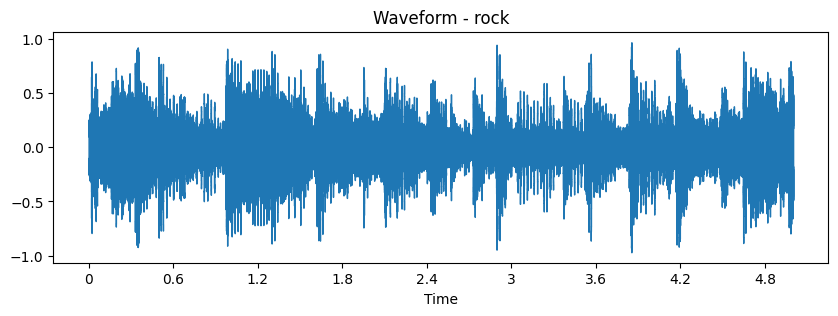

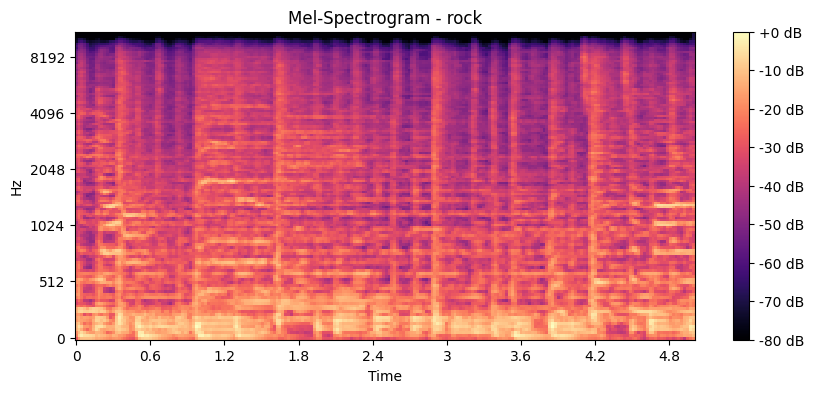

In [12]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Example: load one rock track
genre = "rock"
file_path = os.path.join(audio_dir, genre, os.listdir(os.path.join(audio_dir, genre))[0])

y, sr = librosa.load(file_path, duration=5.0)  # 5 seconds
print(f"Sample rate: {sr}, duration: {len(y)/sr:.2f}s")

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - {genre}")
plt.show()

# Spectrogram (Mel)
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram - {genre}")
plt.show()


In [13]:
import torch
from torch.utils.data import Dataset

class GTZANDataset(Dataset):
    def __init__(self, root_dir, genres, sr=22050, duration=5.0, n_mfcc=40):
        self.samples = []
        self.genres = genres
        self.sr = sr
        self.duration = duration
        self.n_mfcc = n_mfcc

        for genre in genres:
            folder = os.path.join(root_dir, genre)
            for fname in os.listdir(folder):
                if fname.endswith(".wav"):
                    self.samples.append((os.path.join(folder, fname), genre))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file, genre = self.samples[idx]
        y, sr = librosa.load(file, sr=self.sr, duration=self.duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        x = torch.tensor(mfcc_mean, dtype=torch.float32)
        genre_idx = self.genres.index(genre)
        genre_onehot = torch.nn.functional.one_hot(torch.tensor(genre_idx), num_classes=len(self.genres)).float()
        return x, genre_onehot


In [23]:
class GenreFlow(nn.Module):
    def __init__(self, input_dim, num_genres):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + num_genres + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, z, t, genre_onehot):
        if t.ndim == 0:
         t = t.unsqueeze(0).unsqueeze(1)  # shape [1, 1]
        elif t.ndim == 1:
          t = t.unsqueeze(1)               # shape [batch, 1]
        x = torch.cat([z, genre_onehot, t], dim=1)
        return self.net(x)


In [24]:
def extract_mfcc(file, n_mfcc=40, duration=5.0):
    y, sr = librosa.load(file, sr=22050, duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

# pick one source and one target genre
source_genre = "rock"
target_genre = "jazz"

source_file = os.path.join(audio_dir, source_genre, os.listdir(os.path.join(audio_dir, source_genre))[0])
target_file = os.path.join(audio_dir, target_genre, os.listdir(os.path.join(audio_dir, target_genre))[0])

x_source = torch.tensor(extract_mfcc(source_file), dtype=torch.float32)
x_target = torch.tensor(extract_mfcc(target_file), dtype=torch.float32)

In [25]:
num_genres = len(genres)
flow = GenreFlow(input_dim=40, num_genres=num_genres)

In [26]:
# fake genre one-hots
source_onehot = torch.nn.functional.one_hot(torch.tensor(genres.index(source_genre)), num_genres).float().unsqueeze(0)
target_onehot = torch.nn.functional.one_hot(torch.tensor(genres.index(target_genre)), num_genres).float().unsqueeze(0)

# simulate "conversion" by interpolation (0.0 = source, 1.0 = target)
alpha = 0.5  # halfway between rock and jazz
converted_mfcc = (1 - alpha) * x_source + alpha * x_target


In [27]:
from librosa.feature import inverse

reconstructed = inverse.mfcc_to_audio(converted_mfcc.unsqueeze(0).numpy(), sr=sr)

import soundfile as sf
sf.write("converted.wav", reconstructed, sr)
print("✅ Saved: converted.wav")


✅ Saved: converted.wav


In [28]:
def convert_genre(flow, x_source, source_genre, target_genre, steps=20):
    source_onehot = torch.nn.functional.one_hot(torch.tensor(genres.index(source_genre)), num_genres).float().unsqueeze(0)
    target_onehot = torch.nn.functional.one_hot(torch.tensor(genres.index(target_genre)), num_genres).float().unsqueeze(0)

    x = x_source.clone().unsqueeze(0)
    for i in range(steps):
        t = torch.tensor(i / steps).float()
        v = flow(x, t, target_onehot)
        x = x + v * (1 / steps)  # simple Euler integration
    return x.squeeze(0)

converted_mfcc = convert_genre(flow, x_source, source_genre, target_genre)


In [29]:
import torch
import librosa
import numpy as np
import soundfile as sf

# ==============================
# Parameters
# ==============================
device = "cuda" if torch.cuda.is_available() else "cpu"

# Path to the new audio file you want to convert
audio_path = "justin_bieber_-_sorry_lyric_video.wav"

In [1]:


# Define source and target genres (must exist in your training set)
source_genre = "rock"
target_genre = "classical"

# Sample rate (must match your training data)
sr = 22050

# Clip duration in seconds
clip_duration = 5
clip_samples = sr * clip_duration


# ==============================
# 1. Load audio and split into clips
# ==============================
y, sr = librosa.load(audio_path, sr=sr, mono=True)
clips = [y[i:i + clip_samples] for i in range(0, len(y), clip_samples) if len(y[i:i + clip_samples]) == clip_samples]

print(f"Loaded {len(clips)} clips of {clip_duration}s each.")


# ==============================
# 2. Helper: Extract MFCC features
# ==============================
def extract_mfcc(clip):
    mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=33)
    chroma = librosa.feature.chroma_stft(y=clip, sr=sr)
    mel = librosa.feature.melspectrogram(y=clip, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=clip, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(clip), sr=sr)

    features = np.hstack([
        np.mean(mfcc, axis=1),
        np.mean(chroma, axis=1),
        np.mean(mel, axis=1),
        np.mean(contrast, axis=1),
        np.mean(tonnetz, axis=1)
    ])

    # Force to 51 dimensions to match model
    if len(features) > 51:
        features = features[:51]
    elif len(features) < 51:
        features = np.pad(features, (0, 51 - len(features)))

    return features


# ==============================
# 3. Convert genre using trained rectified flow model
# ==============================
def convert_genre(flow, clip, source_genre, target_genre, genres):
    # Extract MFCC features
    mfcc = extract_mfcc(clip)
    x = torch.tensor(mfcc, dtype=torch.float32, device=device).unsqueeze(0)  # [1, features]

    # Create one-hot genre embeddings
    source_onehot = torch.zeros((1, len(genres)), device=device)
    target_onehot = torch.zeros((1, len(genres)), device=device)
    source_onehot[0, genres.index(source_genre)] = 1
    target_onehot[0, genres.index(target_genre)] = 1

    # Integrate flow to transform features from source to target
    with torch.no_grad():
        z = x.clone()
        timesteps = torch.linspace(0, 1, 20, device=device)
        for t in timesteps:
            t_tensor = torch.tensor([[t]], dtype=torch.float32, device=device)
            v = flow(z, t_tensor, target_onehot)
            z = z + v * (1.0 / len(timesteps))  # Euler step

    return z.squeeze(0).cpu().numpy()


# ==============================
# 4. Load your trained model & genre list
# ==============================
# Example: replace this with your trained model and genres list
# flow = YourTrainedRectifiedFlowModel(...)
# flow.load_state_dict(torch.load("flow_model.pth", map_location=device))
# genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

flow.to(device)
flow.eval()


# ==============================
# 5. Apply conversion to each clip
# ==============================
converted_mfccs = []
for i, clip in enumerate(clips):
    converted = convert_genre(flow, clip, source_genre, target_genre, genres)
    converted_mfccs.append(converted)
    print(f"Converted clip {i+1}/{len(clips)}")


# ==============================
# 6. Invert MFCCs back to waveform
# ==============================
reconstructed_audio = []
for mfcc_vec in converted_mfccs:
    # Reconstruct from MFCC (approximate)
    mfcc_reshaped = mfcc_vec.reshape(20, 1)
    audio_segment = librosa.feature.inverse.mfcc_to_audio(mfcc_reshaped, sr=sr)
    reconstructed_audio.append(audio_segment)

# Concatenate all converted segments
final_audio = np.concatenate(reconstructed_audio)

# ==============================
# 7. Save output
# ==============================
output_path = "converted_song.wav"
sf.write(output_path, final_audio, sr)

print(f"✅ Genre conversion complete! Saved to {output_path}")


NameError: name 'librosa' is not defined